<a href="https://colab.research.google.com/github/ruizleandro/Risk-Management-with-LightGBM/blob/master/Risk_Management_with_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the Data and Installing Libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving customer_data.csv to customer_data (2).csv
Saving payment_data.csv to payment_data (2).csv
User uploaded file "customer_data.csv" with length 67750 bytes
User uploaded file "payment_data.csv" with length 500975 bytes


In [131]:
customer_data = pd.read_csv("customer_data.csv")
payment_data = pd.read_csv("payment_data.csv")

# Introduction

## Project's Objective

1. There are two types of credit: good credit and bad credit.
2. The main task is to predict if a customer will be going to pay his credit according to the available data.

> Note: the dataset used for this task is really small (the `customer_data` has 1125 rows, and the `payment_data` has 8250 rows), so that will definitely impact in the accuracy of the final model. 

# Exploratory Data Analysis

## Variable Description

* `payment_data`:
  * id: customer id
  * OVD_t1: number of times overdue type 1
  * OVD_t2: number of times overdue type 2
  * OVD_t3: number of times overdue type 3
  * OVD_sum: total overdue days
  * pay_normal: number of times normal payment
  * prod_code: credit product code
  * prod_limit: credit limit of product
  * update_date: account update date
  * new_balance: current balance of product
  * highest_balance: highest balance in history
  * report_date: date of recent payment

* `customer_data`:
  * id: customer id
  * Categoric and demographical data of the customers have been encoded.
  * label:
    * 1 = high credit risk
    * 0 = low credit risk

## Quick Look to the Data

First, a quick look to the two datasets that I will use for this project:

In [132]:
print("Dataset shape:", customer_data.shape)
customer_data.head()

Dataset shape: (1125, 13)


,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [133]:
customer_data.describe()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781


In [134]:
print("Dataset shape:", payment_data.shape)
payment_data.sort_values(by='id').head()

Dataset shape: (8250, 12)


,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
5451,54982353,0,0,0,0,19,10,NaN,16/07/2011,31677.6,204037.0,14/12/2015
8143,54982353,0,0,0,0,11,2,NaN,21/02/2001,0.0,248874.0,22/06/2007
7670,54982353,0,0,0,0,1,10,NaN,08/01/2006,0.0,1622.0,NaN
7365,54982353,0,0,0,0,1,10,NaN,21/11/2006,0.0,NaN,NaN
7749,54982353,0,0,0,0,0,10,NaN,30/09/2005,0.0,NaN,NaN


In [135]:
payment_data.describe()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,new_balance,highest_balance
count,8.250000e+03,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,2132.000000,8.250000e+03,7.841000e+03
mean,5.782173e+07,0.249091,0.127152,0.369212,187.681697,14.526667,8.232000,85789.702205,1.054042e+05,2.192027e+05
std,1.822724e+06,1.250197,0.860046,2.900320,1804.232570,12.053627,3.533055,74345.828184,1.887704e+06,2.814536e+06
min,5.498235e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,-4.030320e+04,5.010000e+02
25%,5.499050e+07,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,37400.000000,0.000000e+00,2.345300e+04
50%,5.898905e+07,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,68200.000000,0.000000e+00,4.404700e+04
75%,5.899655e+07,0.000000,0.000000,0.000000,0.000000,25.000000,10.000000,112200.000000,2.494800e+04,1.005000e+05
max,5.900624e+07,34.000000,34.000000,35.000000,31500.000000,36.000000,27.000000,660000.000000,1.632120e+08,1.800005e+08


In [136]:
id_counts = payment_data['id'].value_counts().to_frame()
id_counts

,id
58988212,55
54990497,48
58998646,45
58991343,39
58987276,39
...,...
58986809,1
59004100,1
59004658,1
59003724,1


The `payment_data` dataset has 8250 transactions from the 1125 customers of the `customer_data` dataset.

## Dealing with Missing Data

In [137]:
missing_data = customer_data.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

label
False    1125
Name: label, dtype: int64

id
False    1125
Name: id, dtype: int64

fea_1
False    1125
Name: fea_1, dtype: int64

fea_2
False    976
True     149
Name: fea_2, dtype: int64

fea_3
False    1125
Name: fea_3, dtype: int64

fea_4
False    1125
Name: fea_4, dtype: int64

fea_5
False    1125
Name: fea_5, dtype: int64

fea_6
False    1125
Name: fea_6, dtype: int64

fea_7
False    1125
Name: fea_7, dtype: int64

fea_8
False    1125
Name: fea_8, dtype: int64

fea_9
False    1125
Name: fea_9, dtype: int64

fea_10
False    1125
Name: fea_10, dtype: int64

fea_11
False    1125
Name: fea_11, dtype: int64



In [138]:
missing_data = payment_data.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

id
False    8250
Name: id, dtype: int64

OVD_t1
False    8250
Name: OVD_t1, dtype: int64

OVD_t2
False    8250
Name: OVD_t2, dtype: int64

OVD_t3
False    8250
Name: OVD_t3, dtype: int64

OVD_sum
False    8250
Name: OVD_sum, dtype: int64

pay_normal
False    8250
Name: pay_normal, dtype: int64

prod_code
False    8250
Name: prod_code, dtype: int64

prod_limit
True     6118
False    2132
Name: prod_limit, dtype: int64

update_date
False    8224
True       26
Name: update_date, dtype: int64

new_balance
False    8250
Name: new_balance, dtype: int64

highest_balance
False    7841
True      409
Name: highest_balance, dtype: int64

report_date
False    7136
True     1114
Name: report_date, dtype: int64



### `fea_2`

The `fea_2` has 149 missing values, so I'm going to look it closer to know how to deal with it.

In [139]:
customer_data[['fea_2']].describe(include='all')

,fea_2
count,976.000000
mean,1283.911373
std,51.764022
min,1116.500000
25%,1244.000000
50%,1281.500000
75%,1314.500000
max,1481.000000


In [140]:
fea_2_counts = customer_data['fea_2'].value_counts().to_frame()
fea_2_counts

,fea_2
1241.0,37
1214.0,27
1305.5,23
1287.5,21
1223.0,21
...,...
1344.5,1
1194.5,1
1455.5,1
1404.5,1


This feature has 976 records with 158 unique values, so I will fill the missing values with the mean.

In [141]:
average_fea_2 = customer_data['fea_2'].astype(float).mean(axis = 0)
customer_data['fea_2'].replace(np.nan, average_fea_2, inplace = True)

### `highest_balance`

I think that this feature is important for the future development of the model, so I will make sure it does not have missing values.

In [142]:
payment_data[['highest_balance']].describe(include='all')

,highest_balance
count,7.841000e+03
mean,2.192027e+05
std,2.814536e+06
min,5.010000e+02
25%,2.345300e+04
50%,4.404700e+04
75%,1.005000e+05
max,1.800005e+08


In [143]:
highest_balance_counts = payment_data['highest_balance'].value_counts().to_frame()
highest_balance_counts

,highest_balance
100500.0,151
150500.0,102
200500.0,84
30500.0,66
250500.0,54
...,...
30637.0,1
232022.0,1
35678.0,1
32587.0,1


In [144]:
payment_data['highest_balance'].fillna(0,inplace=True)

## Graphic Analysis

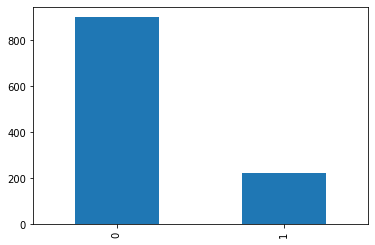

In [145]:
customer_data.label.value_counts().plot(kind = 'bar')

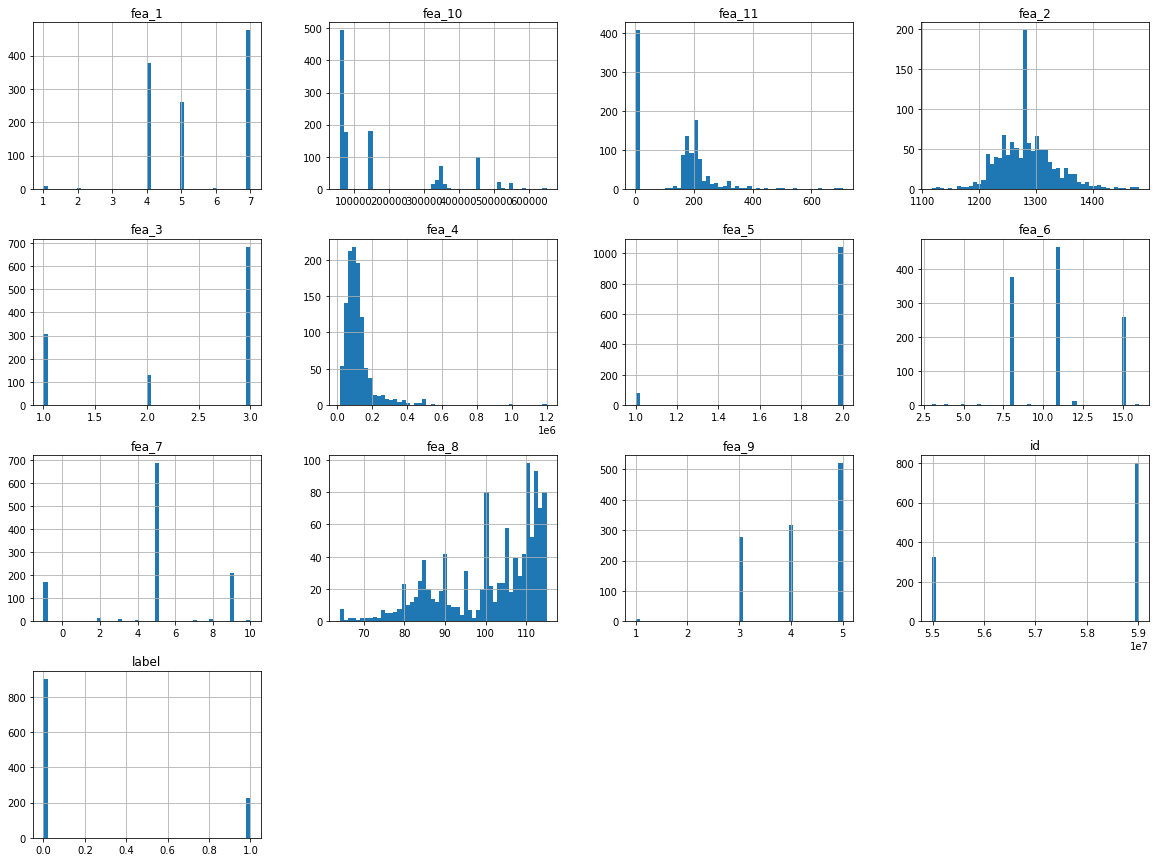

In [146]:
customer_data.hist(bins=50, figsize=(20,15))
plt.show()

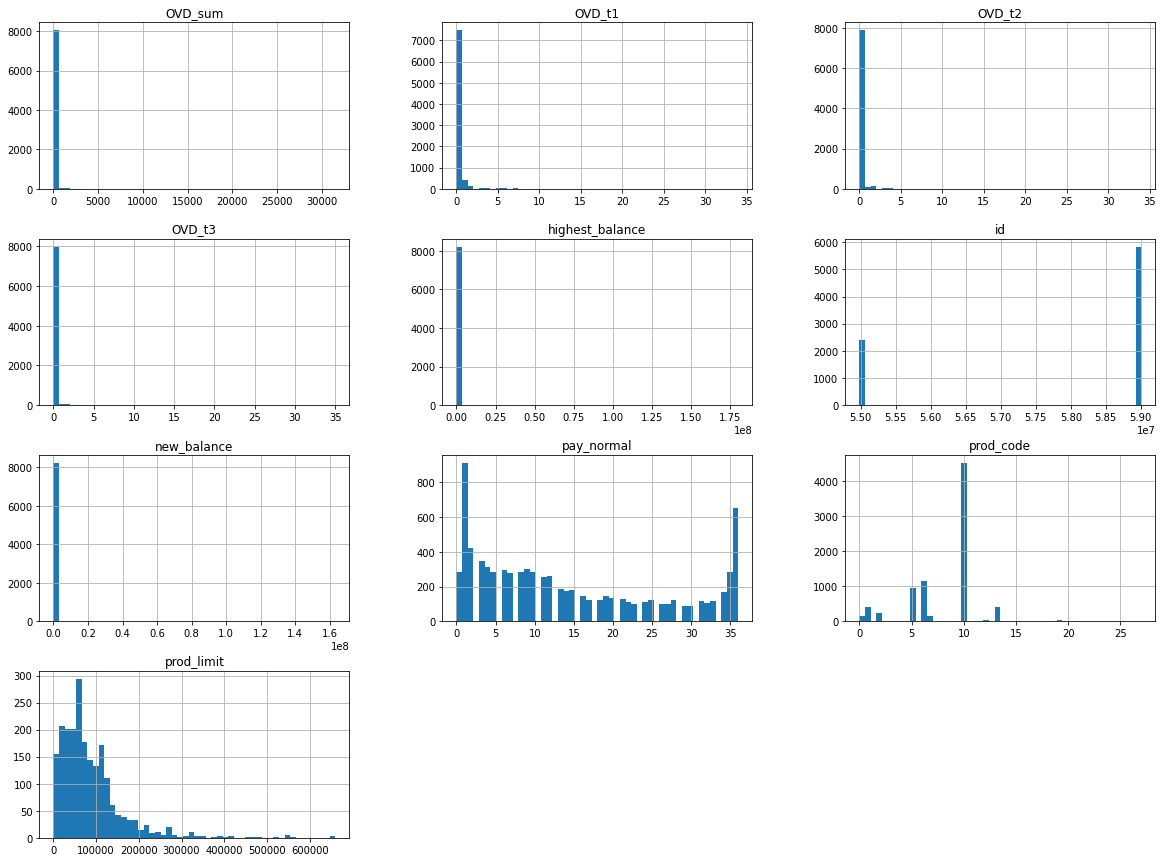

In [147]:
payment_data.hist(bins=50, figsize=(20,15))
plt.show()

# Data Transformation

## Grouping Features According to the ID

I would like to have all the data into a single dataset, so I am going to group the most important features of the `payment_data` dataset according to the `id` of the customer, so is easier to join this data with the `customer_data` dataset.

I consider the following to be the most important features:

* `prod_code`: is the type of product that the customer used for the payment. 

* `new_balance`: is the mean of the balance of every product of the customer after the payment.

* `OVD_t1`: is the sum of all times of overdue type 1 for the totality of the products of a customer.

* `OVD_t2`: is the sum of all times of overdue type 2 for the totality of the products of a customer.

* `OVD_t3`: is the sum of all times of overdue type 3 for the totality of the products of a customer.

* `pay_normal`: the sum of normal payments for all the products  of the customer.

### Grouping a Single Feature with the `id` 

In [148]:
df_0 = payment_data.groupby(['id'])['prod_code'].apply(list).reset_index()
print(df_0.shape)
df_0.head(30)

(1125, 2)


,id,prod_code
0,54982353,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
1,54982356,"[27, 27, 10, 6, 6, 12, 10]"
2,54982387,"[1, 6, 6, 6, 6, 1, 10, 10, 1, 10, 10]"
3,54982463,"[5, 13]"
4,54982530,"[10, 10, 10, 10]"
5,54982549,"[17, 6, 6, 1, 2, 5, 17, 17, 17, 17]"
6,54982579,"[2, 10, 10, 10, 10, 10, 2, 10, 10, 1, 10, 10, ..."
7,54982665,"[10, 10, 5, 10]"
8,54982697,"[10, 10]"
9,54982721,"[10, 6, 1, 5, 13, 10, 5, 10, 13, 12]"


In [149]:
df_1 = payment_data.groupby(['id'])['new_balance'].apply(np.mean, axis=0).reset_index()
print(df_1.shape)
df_1.head(30)

(1125, 2)


,id,new_balance
0,54982353,42033.133333
1,54982356,2277.771429
2,54982387,117455.127273
3,54982463,39890.400000
4,54982530,1261.200000
5,54982549,410060.400000
6,54982579,86454.654545
7,54982665,40112.400000
8,54982697,8752.800000
9,54982721,49843.440000


In [150]:
from functools import reduce

df_OVD_t1 = payment_data.groupby(['id'])['OVD_t1'].apply(np.sum, axis=0).reset_index()
df_OVD_t2 = payment_data.groupby(['id'])['OVD_t2'].apply(np.sum, axis=0).reset_index()
df_OVD_t3 = payment_data.groupby(['id'])['OVD_t3'].apply(np.sum, axis=0).reset_index()
OVD_dfs = [df_OVD_t1, df_OVD_t2, df_OVD_t3]
df_2 = reduce(lambda left,right: pd.merge(left,right,on='id'), OVD_dfs)
print(df_2.shape)
df_2.head(25)

(1125, 4)


,id,OVD_t1,OVD_t2,OVD_t3
0,54982353,3,2,38
1,54982356,0,0,0
2,54982387,3,0,0
3,54982463,0,0,0
4,54982530,0,0,0
5,54982549,6,2,0
6,54982579,1,0,0
7,54982665,0,2,26
8,54982697,0,0,0
9,54982721,2,1,43


In [151]:
df_3 = payment_data.groupby(['id'])['pay_normal'].apply(np.sum, axis=0).reset_index()
print(df_3.shape)
df_3.head(30)

(1125, 2)


,id,pay_normal
0,54982353,229
1,54982356,117
2,54982387,246
3,54982463,34
4,54982530,56
5,54982549,211
6,54982579,323
7,54982665,34
8,54982697,45
9,54982721,109


### Grouping All the Features

In [152]:
dfs = [df_0, df_1, df_2, df_3]
df_final = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)
print(df_final.shape)
df_final.head(25)

(1125, 7)


,id,prod_code,new_balance,OVD_t1,OVD_t2,OVD_t3,pay_normal
0,54982353,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",42033.133333,3,2,38,229
1,54982356,"[27, 27, 10, 6, 6, 12, 10]",2277.771429,0,0,0,117
2,54982387,"[1, 6, 6, 6, 6, 1, 10, 10, 1, 10, 10]",117455.127273,3,0,0,246
3,54982463,"[5, 13]",39890.400000,0,0,0,34
4,54982530,"[10, 10, 10, 10]",1261.200000,0,0,0,56
5,54982549,"[17, 6, 6, 1, 2, 5, 17, 17, 17, 17]",410060.400000,6,2,0,211
6,54982579,"[2, 10, 10, 10, 10, 10, 2, 10, 10, 1, 10, 10, ...",86454.654545,1,0,0,323
7,54982665,"[10, 10, 5, 10]",40112.400000,0,2,26,34
8,54982697,"[10, 10]",8752.800000,0,0,0,45
9,54982721,"[10, 6, 1, 5, 13, 10, 5, 10, 13, 12]",49843.440000,2,1,43,109


Now that I have the dataset with the data grouped by `id`, I am going to merge it with the `customer_data` dataset.

In [153]:
dfs = [df_final, customer_data]
complete_df = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)
print(complete_df.shape)
complete_df.head(30)

(1125, 19)


,id,prod_code,new_balance,OVD_t1,OVD_t2,OVD_t3,pay_normal,label,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,54982353,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",42033.133333,3,2,38,229,0,1,1130.000000,2,1000000.0,2,4,-1,100,5,650018,1.000000
1,54982356,"[27, 27, 10, 6, 6, 12, 10]",2277.771429,0,0,0,117,0,1,1391.000000,1,1200000.0,2,5,-1,64,5,361026,1.000000
2,54982387,"[1, 6, 6, 6, 6, 1, 10, 10, 1, 10, 10]",117455.127273,3,0,0,246,1,2,1349.000000,1,286000.0,2,3,-1,80,3,361003,1.000000
3,54982463,"[5, 13]",39890.400000,0,0,0,34,0,5,1272.500000,3,70000.0,2,15,5,113,5,60033,167.122709
4,54982530,"[10, 10, 10, 10]",1261.200000,0,0,0,56,0,5,1272.500000,3,120000.0,1,15,5,110,5,72000,187.082869
5,54982549,"[17, 6, 6, 1, 2, 5, 17, 17, 17, 17]",410060.400000,6,2,0,211,1,5,1326.500000,3,30000.0,2,15,5,110,5,60005,1.000000
6,54982579,"[2, 10, 10, 10, 10, 10, 2, 10, 10, 1, 10, 10, ...",86454.654545,1,0,0,323,0,5,1338.500000,3,325000.0,2,15,5,110,5,60033,316.227766
7,54982665,"[10, 10, 5, 10]",40112.400000,0,2,26,34,1,5,1245.500000,3,77000.0,2,15,5,109,5,151300,244.948974
8,54982697,"[10, 10]",8752.800000,0,0,0,45,0,5,1320.500000,3,130000.0,2,15,5,85,5,60047,212.132034
9,54982721,"[10, 6, 1, 5, 13, 10, 5, 10, 13, 12]",49843.440000,2,1,43,109,1,5,1283.911373,2,90000.0,2,15,5,92,5,72014,1.000000


## Correlations

In [154]:
corr_matrix = complete_df.corr(method='pearson')
corr_matrix['label'].sort_values(ascending=False)

label          1.000000e+00
new_balance    9.159205e-02
OVD_t2         8.734369e-02
OVD_t1         5.735300e-02
OVD_t3         5.640641e-02
fea_3          5.565787e-02
fea_1          5.207118e-02
fea_6          2.890698e-02
fea_5          1.729286e-02
fea_11         2.444255e-03
fea_10         8.808212e-04
fea_9          5.105675e-17
fea_7         -1.227143e-02
fea_8         -2.125122e-02
id            -2.461878e-02
fea_2         -7.236856e-02
pay_normal    -1.292819e-01
fea_4         -1.314593e-01
Name: label, dtype: float64

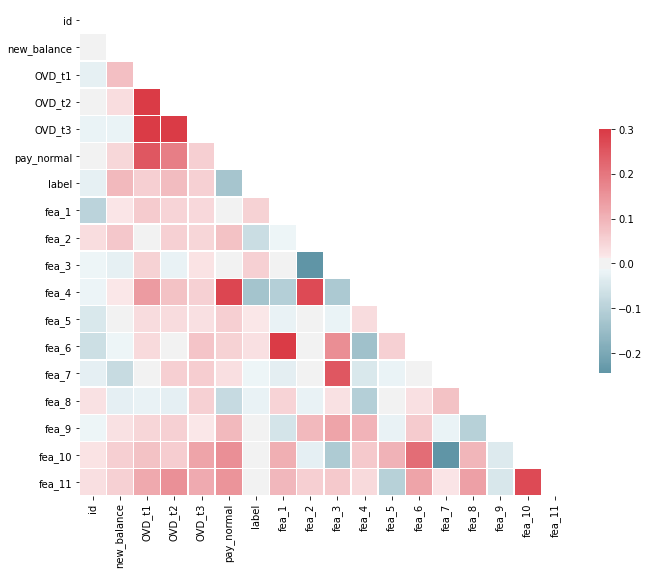

In [155]:
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Apparently, the features of the `customer_data` dataset have little correlation with the `label` feature.

## Splitting into Train and Test Data

In [156]:
from sklearn.model_selection import train_test_split

x_data = complete_df.copy().drop(['label'], axis=1).drop(['prod_code'], axis=1)
y_data = complete_df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.30,
                                                    random_state=42,
                                                    stratify=y_data)

print("Train samples: {}\nTest samples: {}".format(len(X_train), len(X_test)))

Train samples: 787
Test samples: 338


# Model Development

## Model Training with Grid Search

In [157]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

estimator = lgb.LGBMClassifier(learning_rate=0.2, 
                               metric='l1', 
                               n_estimators=24, 
                               objetive='binary',
                               max_depth=7,
                               num_leaves=40,
                               is_unbalance=True,
                               max_bin=1000)

param_grid = {
    'n_estimators': [x for x in range(16,32)],
    'learning_rate': [0.368, 0.369, 0.371, 0.372, 0.373],
    'num_leaves':[25, 40, 70, 100]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_error'],
        early_stopping_rounds = 5)

Streaming output truncated to the last 5000 lines.
[5]	valid_0's l1: 0.384258	valid_0's binary_error: 0.278107	valid_0's auc: 0.690332
[6]	valid_0's l1: 0.379426	valid_0's binary_error: 0.301775	valid_0's auc: 0.685049
Early stopping, best iteration is:
[1]	valid_0's l1: 0.362008	valid_0's binary_error: 0.221893	valid_0's auc: 0.673393
[1]	valid_0's l1: 0.357262	valid_0's binary_error: 0.254438	valid_0's auc: 0.66092
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.375514	valid_0's binary_error: 0.275148	valid_0's auc: 0.654602
[3]	valid_0's l1: 0.385433	valid_0's binary_error: 0.272189	valid_0's auc: 0.645806
[4]	valid_0's l1: 0.3872	valid_0's binary_error: 0.292899	valid_0's auc: 0.629548
[5]	valid_0's l1: 0.387622	valid_0's binary_error: 0.316568	valid_0's auc: 0.622876
[6]	valid_0's l1: 0.385835	valid_0's binary_error: 0.307692	valid_0's auc: 0.625572
Early stopping, best iteration is:
[1]	valid_0's l1: 0.357262	valid_0's binary_error: 0.254438	valid

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      is_unbalance=True, learning_rate=0.2,
                                      max_bin=1000, max_depth=7, metric='l1',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=24,
                                      n_jobs=-1, num_leaves=40, objective=None,
                                      objetive='bin...
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid=

In [158]:
gridsearch.best_params_

{'learning_rate': 0.368, 'n_estimators': 16, 'num_leaves': 25}

In [179]:
lightgbm = lgb.LGBMClassifier(learning_rate=0.37, 
                              n_estimators=25,
                              max_depth=7,
                              num_leaves=25,
                              is_unbalance=True,
                              max_bin=1000)
lightgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_error'],
early_stopping_rounds=5)

[1]	valid_0's binary_error: 0.198225	valid_0's auc: 0.70305	valid_0's binary_logloss: 0.491608
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_error: 0.233728	valid_0's auc: 0.719199	valid_0's binary_logloss: 0.511073
[3]	valid_0's binary_error: 0.248521	valid_0's auc: 0.709532	valid_0's binary_logloss: 0.53112
[4]	valid_0's binary_error: 0.266272	valid_0's auc: 0.726171	valid_0's binary_logloss: 0.531924
[5]	valid_0's binary_error: 0.263314	valid_0's auc: 0.719063	valid_0's binary_logloss: 0.54377
[6]	valid_0's binary_error: 0.292899	valid_0's auc: 0.688562	valid_0's binary_logloss: 0.561967
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.198225	valid_0's auc: 0.70305	valid_0's binary_logloss: 0.491608


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.37,
               max_bin=1000, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=25,
               n_jobs=-1, num_leaves=25, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## Model Prediction and Evaluation

In [180]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

y_pred = lightgbm.predict(X_test, num_iteration=lightgbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null accuracy is:', max(y_test.mean(), 1 - y_test.mean()))

The accuracy of prediction is: 0.8017751479289941
The roc_auc_score of prediction is: 0.5953703703703704
The null accuracy is: 0.7988165680473372


Confusion matrix, without normalization
[[254  16]
 [ 51  17]]
Normalized confusion matrix
[[0.94074074 0.05925926]
 [0.75       0.25      ]]


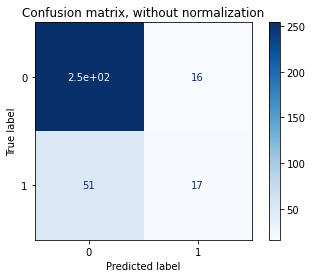

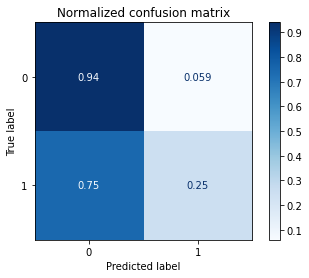

In [216]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lightgbm, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Feature Importances

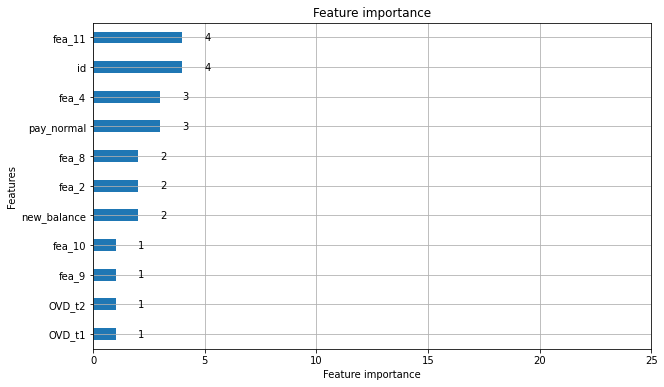

In [184]:
ax = lgb.plot_importance(lightgbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,25), ylim = (-.5, 10.5), 
                         figsize = (10,6))
plt.show()

The final accuracy of the model is 0.802. It is not the most accurate model but is enough for the small dataset that I used for the train stage. 

The next time, I could use a bigger dataset so we can be able to see the real capalbiites of this algorithm.